#Unixversal Team Members:

1. Raden Bayu Setya N. (Leader)
2. Rafi Rosyadi
3. Josin Sitinjak


# Table of Contents
* Introduction
* Preprocessing
* Exploratory Data Analysis and Visualizations
* Feature Selection, Extraction & Engineering
* Data Splitting and Test data processing
* Analyzing Several Models on the Dataset
    - Ensemble of Models
    - Models with Hyper Parameter Optimization (GSCV & RSCV)
* Final Notes & Submission

# 1. Introduction


> The Objective is to perform a multilabel classification of whether a person will/will not take the:
  >  1. H1N1 vaccine
  >  2. Seasonal Flu vaccine

In [ ]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.6 MB/s eta 0:00:00


In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.4 MB/s eta 0:00:00


In [ ]:
### Necessary imports ###

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import sklearn as sk
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score,f1_score,accuracy_score
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier as RF
import lightgbm as lgb
from xgboost import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import PolynomialFeatures
from catboost import Pool,CatBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import svm, model_selection,tree, linear_model, neighbors, naive_bayes, ensemble
from sklearn import discriminant_analysis, gaussian_process

# 2. Preprocessing




Reading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X = pd.read_csv('/content/drive/MyDrive/FINDIT 2023/training_set_features.csv')
Y = pd.read_csv('/content/drive/MyDrive/FINDIT 2023/training_set_labels.csv')

In [ ]:
print('Shape of X: ',X.shape)
print('Shape of Y: ',Y.shape)

Shape of X:  (26707, 36)
Shape of Y:  (26707, 3)


> We see that there are 36 columns/features in the training set

> There are 3 columns in the target file(ground truth) which include respondent_id, h1n1_vaccine,seasonal_vaccine

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [ ]:
X.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


Several features including a persons 'behavior' and his/her 'opinion' about the vaccine, marital status, geographic location all are found, so the data consists a significantly large amount of info

In [ ]:
X.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

In [ ]:
### Joining the X & Y into a single dataframe ###
Z = Y
Z.drop('respondent_id',axis = 1,inplace = True)
frames = [X,Z]
data = pd.concat(frames,axis=1)

Checking out the number of NULLs/NaNs

In [ ]:
data.isnull().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

Columns **'health_insurance', 'employment_industry' , 'employment_occupation'** contain too many NULLs

In [ ]:
# close to half the values of these columns are NULL so discarding
data.drop(['health_insurance','employment_industry','employment_occupation'],axis=1,inplace = True)

# 3. Exploratory Data Analysis and Visualizations


### Firstly Analyzing the number of people who took each vaccine

In [ ]:
#sns.factorplot('h1n1_vaccine',data=Y,kind='count',size = 3.5)
#sns.factorplot('seasonal_vaccine',data=Y,kind='count',size = 3.5)

Considerably larger number of people have chosen to take the seasonal flu vaccine compared to those who took the H1N1 vaccine

### Next Finding the categorical features present in the data

In [ ]:
str_cols = data.select_dtypes(include = 'object').columns
data[str_cols].head()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City"
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City"
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City"
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City"


There are 10 categorical features!

### Populating the NULLs/NaNs with suitable substitutes

P.S: All Categorical features which are NULL are substituted with the mode of data, and the Numeric features with NULLs are substituted with the means

In [ ]:
# All the NULL values are populated with the mode
for col in data.columns:
    if data[col].isnull().sum() and data[col].dtypes != 'object':
        data[col].loc[(X[col].isnull())] = data[col].median()
for col in data.columns:
    if data[col].isnull().sum() and data[col].dtypes == 'object':
        data[col].loc[(data[col].isnull())] = data[col].mode().max()

Sanity Check below!!

In [ ]:
data.isnull().sum()

respondent_id                  0
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_region                 0
census_msa

### Categorical Features are encoded using Label Encodings

P.S: Please consider trying out Mean Encodings, One Hot Encoding or Ordinal Encodings and notice the differences

In [ ]:
LE = LabelEncoder()
for col in str_cols:
    data[col] = LE.fit_transform(data[col]) # Converts to int64

Sanity Check again!

In [ ]:
data[str_cols].head()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa
0,3,1,3,0,2,1,0,1,8,2
1,1,0,3,1,2,1,1,0,1,0
2,0,2,3,1,0,1,0,0,9,0
3,4,0,3,0,2,1,1,1,5,1
4,2,3,3,0,0,0,0,0,9,0


### Plotting Correlation Maps with the set of Encoded and Null Populated Features

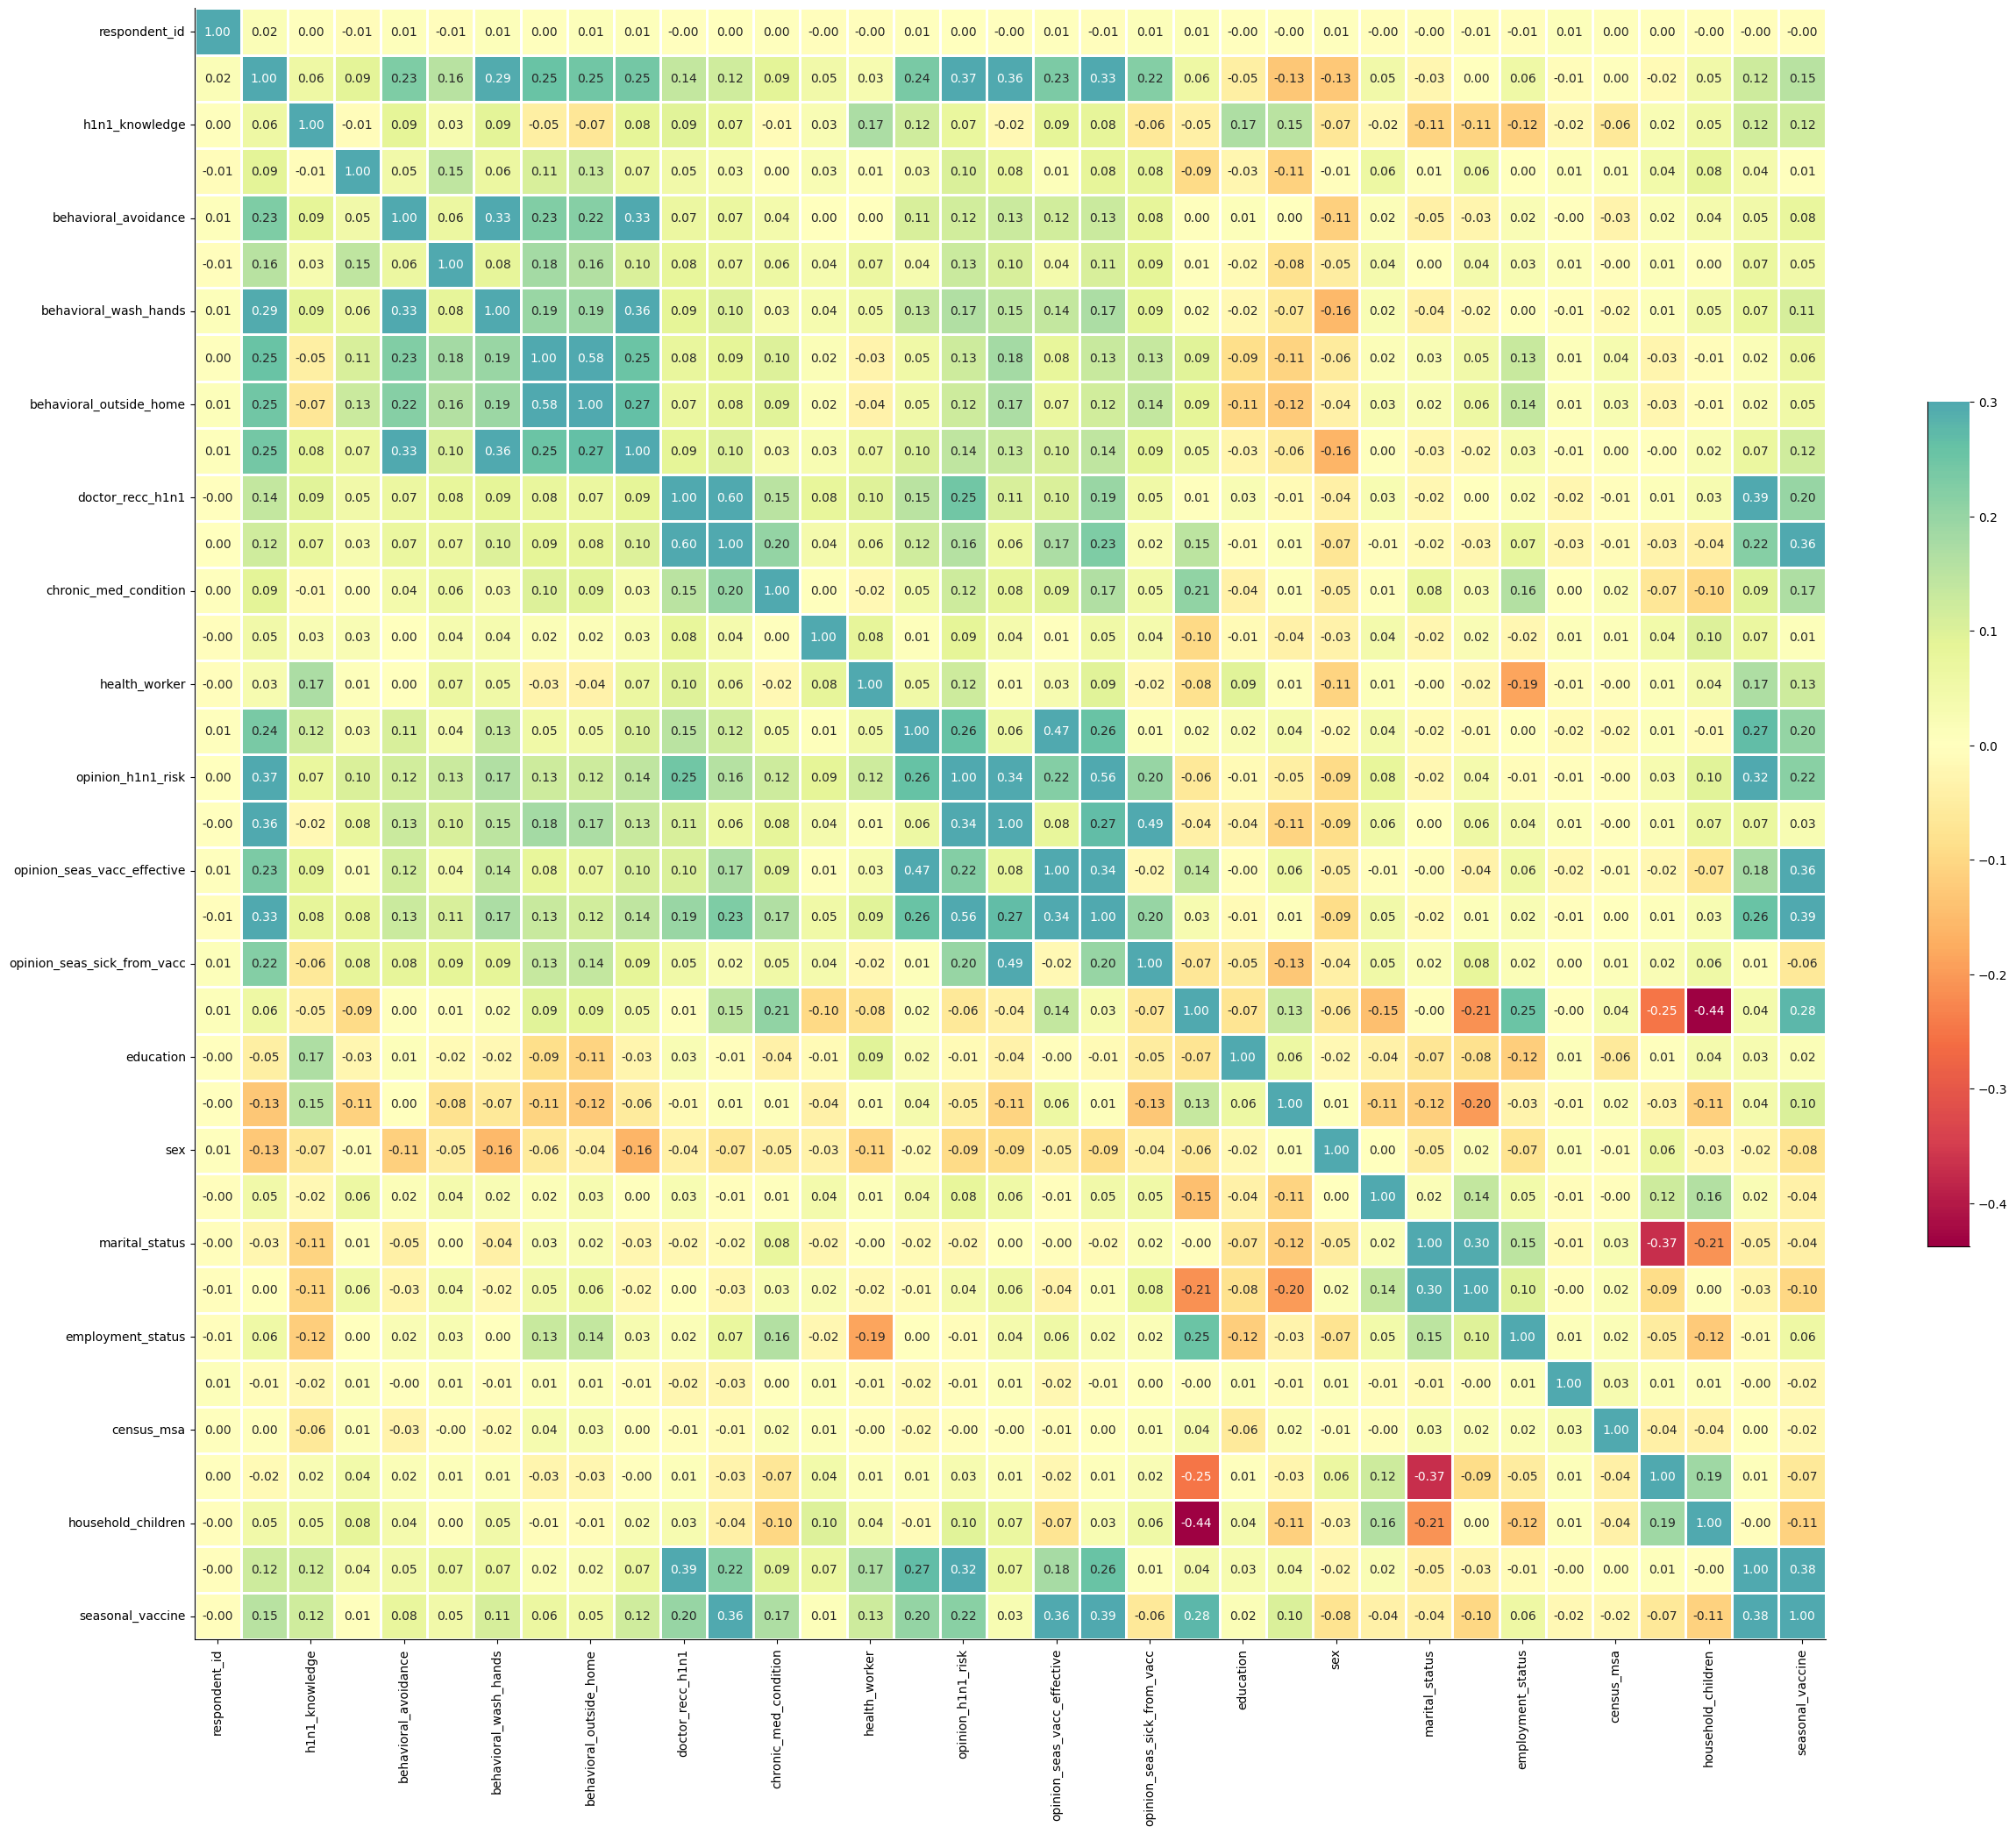

In [ ]:
corr = data.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='Spectral')
sns.despine()
g.figure.set_size_inches(30,25)

plt.show()

*  High Positive correlations between the 'behavioral_features' is noted, some of them may be redundant.

*  High Positive Correlations between opinion of h1n1 risk, doctor recommendation of vaccines Vs whether the person really took the vaccine. Seems fairly obvious

*  Overall the data features seems to be positively correlating with the act of taking the vaccination, except with some rare differences

* Can mainly notice that there are many redundant features/sparsely correlated features which should be taken care of.

### Now Plotting the Heatmap of all the Categorical features which were label encoded for a better idea

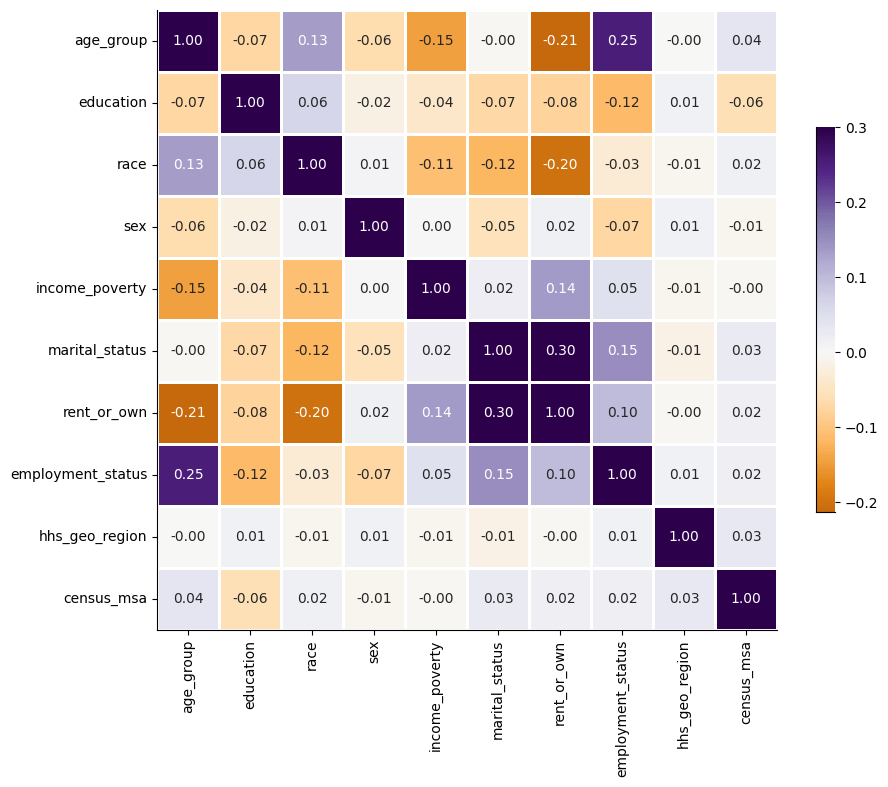

In [ ]:
datum = data[str_cols]
corr = datum.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='PuOr')
sns.despine()
g.figure.set_size_inches(10,10)

plt.show()

### Abundance of plots below!

* #### Pairwise Correlation plots of all the relevant and majorly significant features are given below.
* #### Many features which are neutral and of no 'suggestive' value to the predictions should be removed later on to avoid redundancy.

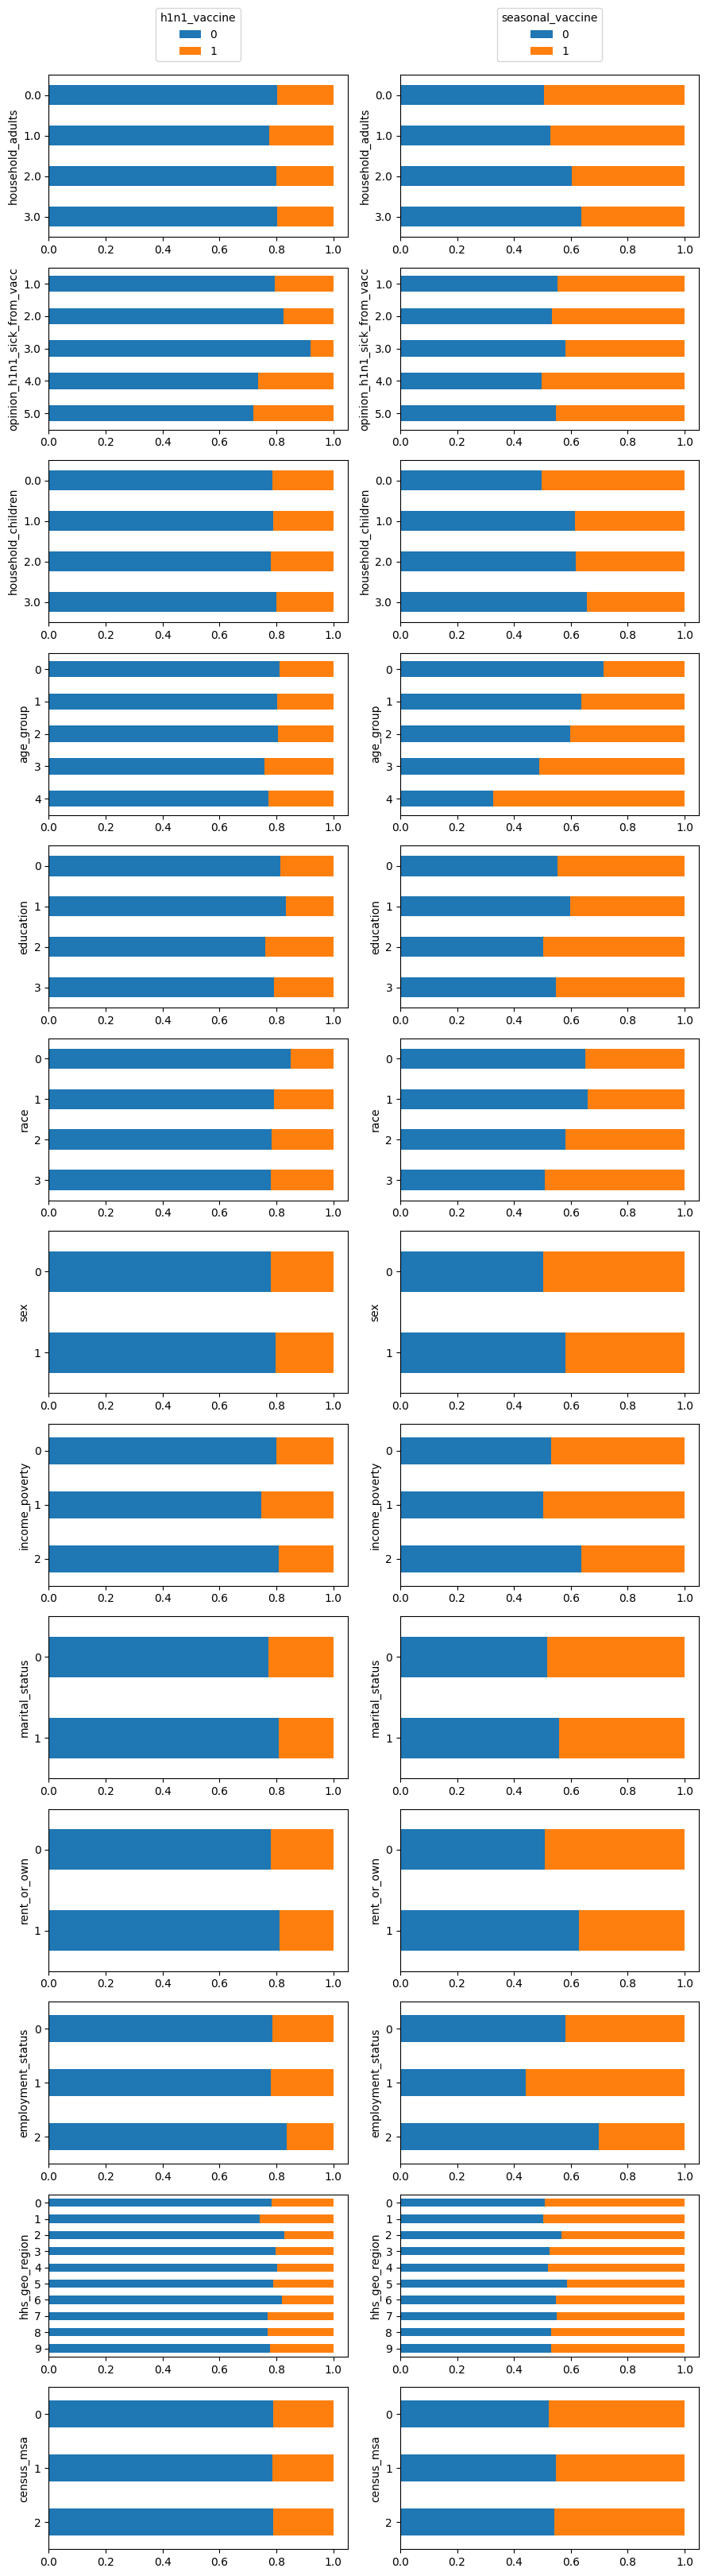

In [ ]:
def vaccination_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of vaccination rate for `target` against
    `col`.

    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes
            object to attach plot to
    """
    counts = (data[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

cols_to_plot = [
     'household_adults','opinion_h1n1_sick_from_vacc',
       'household_children', 'age_group', 'education', 'race',
       'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa'

]

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', data, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', data, ax=ax[idx, 1]
    )

ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

* Census MSA, Race or Geographic Region don't seem to be suggestive and are kind of neutral. Might not be that helpful
* Employment status, Living on Rent and Marital Status maybe relevant for H1N1, but not as such for Seasonal
* Since there are a majority of people who have taken Seasonal compared to H1N1 vaccine, we might as well focus on the ones relevant to seasonal more, as there is a clearer distinction.

### Addition EDA

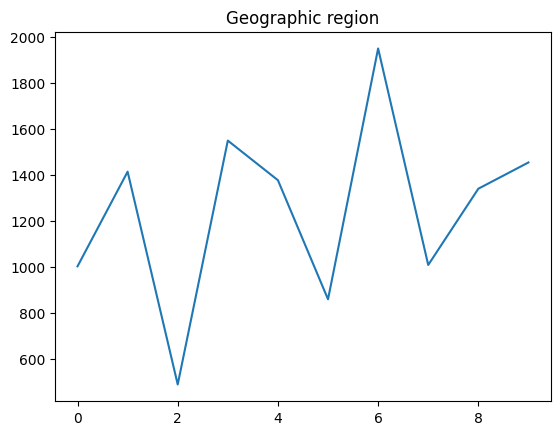

In [ ]:
df = data[data["seasonal_vaccine"] == 1].groupby(data['hhs_geo_region']).sum()
plt.title('Geographic region')
plt.plot(df['seasonal_vaccine'])
plt.show()
### people living in geographic regions 1,3,6 are more likely to get vaccinated than the rest

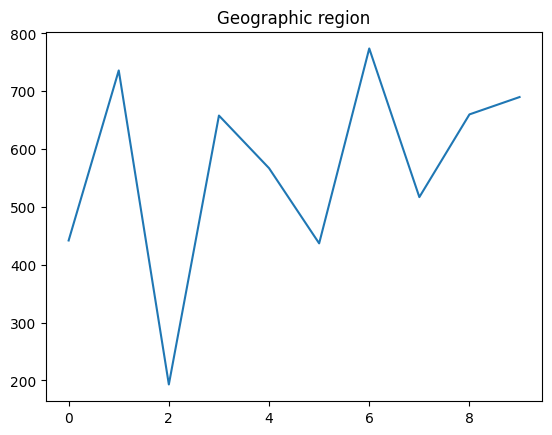

In [ ]:
df = data[data["h1n1_vaccine"] == 1].groupby(data['hhs_geo_region']).sum()
plt.title('Geographic region')
plt.plot(df['h1n1_vaccine'])
plt.show()

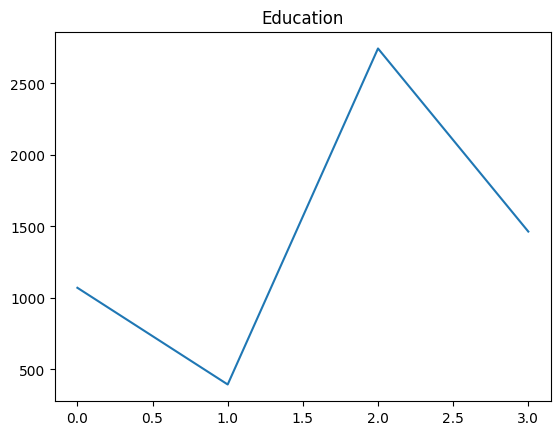

In [ ]:
df = data[data["h1n1_vaccine"] == 1].groupby(data['education']).sum()
plt.title('Education')
plt.plot(df['h1n1_vaccine'])
plt.show()

# 4. Feature Selection, Extraction & Engineering

### Creating a new feature 'cleanliness' which combines the behaviour's

In [ ]:
data['cleanliness'] =  data['behavioral_antiviral_meds']+ data['behavioral_avoidance']+\
                        data['behavioral_face_mask']+data['behavioral_wash_hands']+\
                       data['behavioral_large_gatherings'] + data['behavioral_outside_home']+\
                       data['behavioral_touch_face']

In [ ]:
data['cleanliness']

0        2.0
1        4.0
2        1.0
3        3.0
4        4.0
        ... 
26702    2.0
26703    2.0
26704    5.0
26705    1.0
26706    1.0
Name: cleanliness, Length: 26707, dtype: float64

In [ ]:
#sns.factorplot('cleanliness',kind = 'count',data = data)

Checking the total number of people who have taken the H1N1 vaccine

In [ ]:
print(data[data["h1n1_vaccine"]==1].count()[1])

5674


### Creating Plots for the new feature for each vaccine to check the correlation

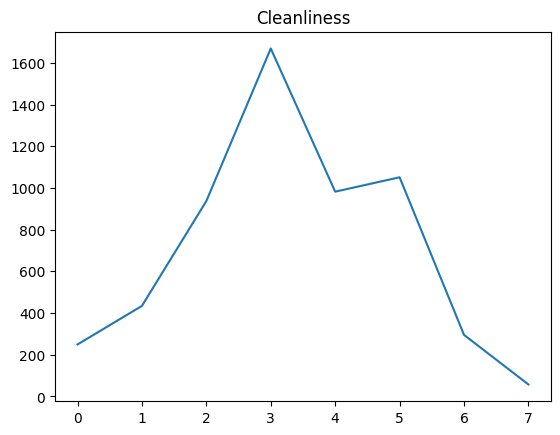

In [ ]:
df = data[data["h1n1_vaccine"] == 1].groupby(data['cleanliness']).sum()
plt.title('Cleanliness')
plt.plot(df['h1n1_vaccine'])
plt.show()

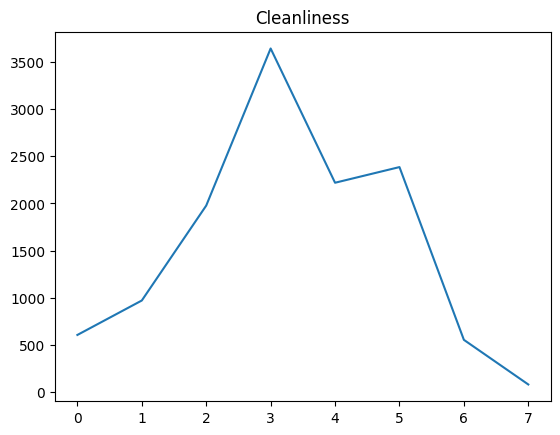

In [ ]:
df = data[data["seasonal_vaccine"] == 1].groupby(data['cleanliness']).sum()
plt.title('Cleanliness')
plt.plot(df['seasonal_vaccine'])
plt.show()

People with cleanliness 2 or above are more likely to get vaccinated than the rest

### Creating a new feature 'opinion' which combines the several 'opinion' columns

In [ ]:
data['opinion'] = data['opinion_h1n1_vacc_effective'] + data['opinion_h1n1_risk']+\
                  data['opinion_h1n1_sick_from_vacc'] + data['opinion_seas_vacc_effective']+\
                  data['opinion_seas_risk'] + data['opinion_seas_sick_from_vacc']

In [ ]:
#sns.factorplot('opinion',kind = 'count',data = data,size=9)

Ooh! a normal distribution like plot is always good to see!

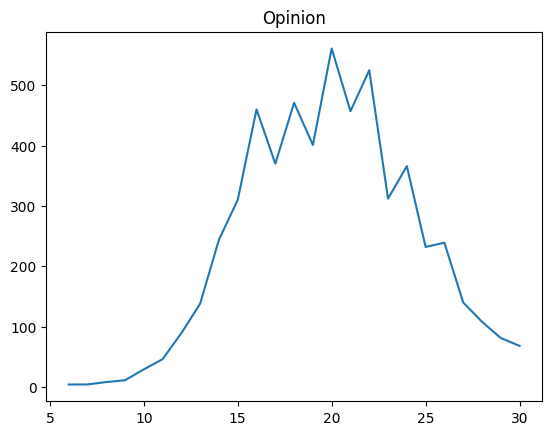

In [ ]:
df = data[data["h1n1_vaccine"] == 1].groupby(data['opinion']).sum()
plt.title('Opinion')
plt.plot(df['h1n1_vaccine'])
plt.show()

### Creating seperate opinions for both vaccine's

In [ ]:
data['opinion_h1n1'] = data['opinion_h1n1_vacc_effective'] + data['opinion_h1n1_risk']-\
                  data['opinion_h1n1_sick_from_vacc']
data['opinion_seasonal'] = data['opinion_seas_vacc_effective']+\
                  data['opinion_seas_risk'] - data['opinion_seas_sick_from_vacc']

### Engineering some more features!

In [ ]:
data['concern>=2'] = np.where(data['h1n1_concern']>=2,1,0)
# Since those who have concern>=2 have a pronounced effect on vaccination

data['good_opinion_vacc'] = np.where(data['opinion_seas_vacc_effective'] == 3,1,0)
#If the opinion is 3 it means he/she has a good opinion and is more likely to take the vaccine

data['good_knowledge'] = np.where(data['h1n1_knowledge'] == 2,1,0)
#Same kind of logic as mentioned previously

In [ ]:
data['risk'] = np.where(data['opinion_h1n1_risk']>=4,1,0)

#data['sick'] = np.where(data['opinion_h1n1_sick_from_vacc'] == 3,1,0)

### Generating a column combining concern and knowledge, since they have seemingly good correlations!

data['concern_knowledge'] = data['h1n1_concern']+data['h1n1_knowledge']

## square of age group to subtely improve the correlation of that feature with the vaccine probabilty
data['a^2'] = data['age_group']*data['age_group']

### Checking everythig out!

In [ ]:
data.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'h1n1_vaccine',
       'seasonal_vaccine', 'cleanliness', 'opinion', 'opinion_h1n1',
       'opinion_seasonal', 'concern>=2', 'good_opinion_vacc', 'good_knowledge',
       'risk', 'concern_knowledge', 'a^2'],
      dt

In [ ]:
data.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,cleanliness,opinion,opinion_h1n1,opinion_seasonal,concern>=2,good_opinion_vacc,good_knowledge,risk,concern_knowledge,a^2
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,2.0,11.0,2.0,1.0,0,0,0,0,1.0,9
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,4.0,23.0,5.0,2.0,1,0,1,1,5.0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,12.0,3.0,3.0,0,0,0,0,2.0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,3.0,21.0,1.0,8.0,0,0,0,0,2.0,16
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,4.0,16.0,4.0,0.0,1,1,0,0,3.0,4


### Removing all the redundant, irrelevant and non-contributory features

In [ ]:
##### Removing seemingly irrelevant features ######

data.drop(['race','child_under_6_months','opinion_h1n1_sick_from_vacc','opinion_seas_sick_from_vacc','household_adults','behavioral_antiviral_meds','behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_antiviral_meds','marital_status',
           'behavioral_avoidance','behavioral_face_mask','income_poverty','hhs_geo_region','employment_status','education','census_msa'],axis=1,inplace = True)

Y_label = data[['h1n1_vaccine','seasonal_vaccine']]

### Whisker plots

Below plot indicates that there are few outliers and mostly similar distributions for doctor reccomendation (highly correlated feature) and opinion (an engineered feature).

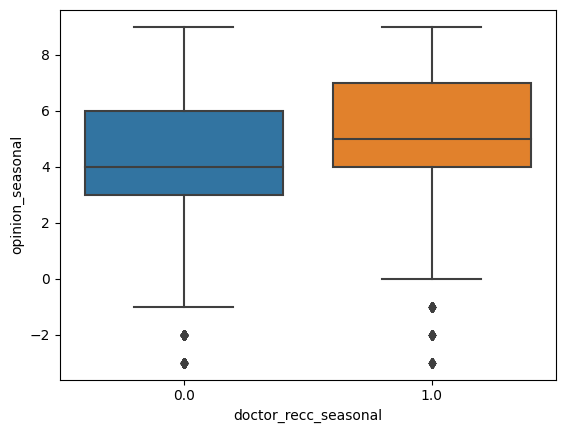

In [ ]:
ax = sns.boxplot(x="doctor_recc_seasonal", y="opinion_seasonal", data=data)

cleanliness (an engineered feature) vs the 'opinion seasonal' ( highly correlated feature)

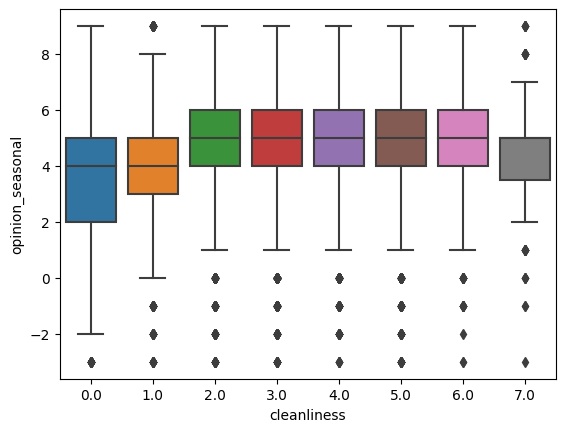

In [ ]:
ax = sns.boxplot(x="cleanliness", y="opinion_seasonal", data=data)

Cleanliness and Opinion

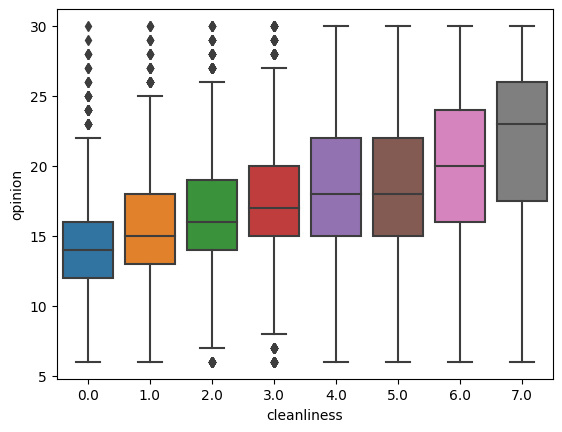

In [ ]:
ax = sns.boxplot(x="cleanliness", y="opinion", data=data)

In [ ]:
data.shape

(26707, 29)

### A final Correlation Map with our selected features

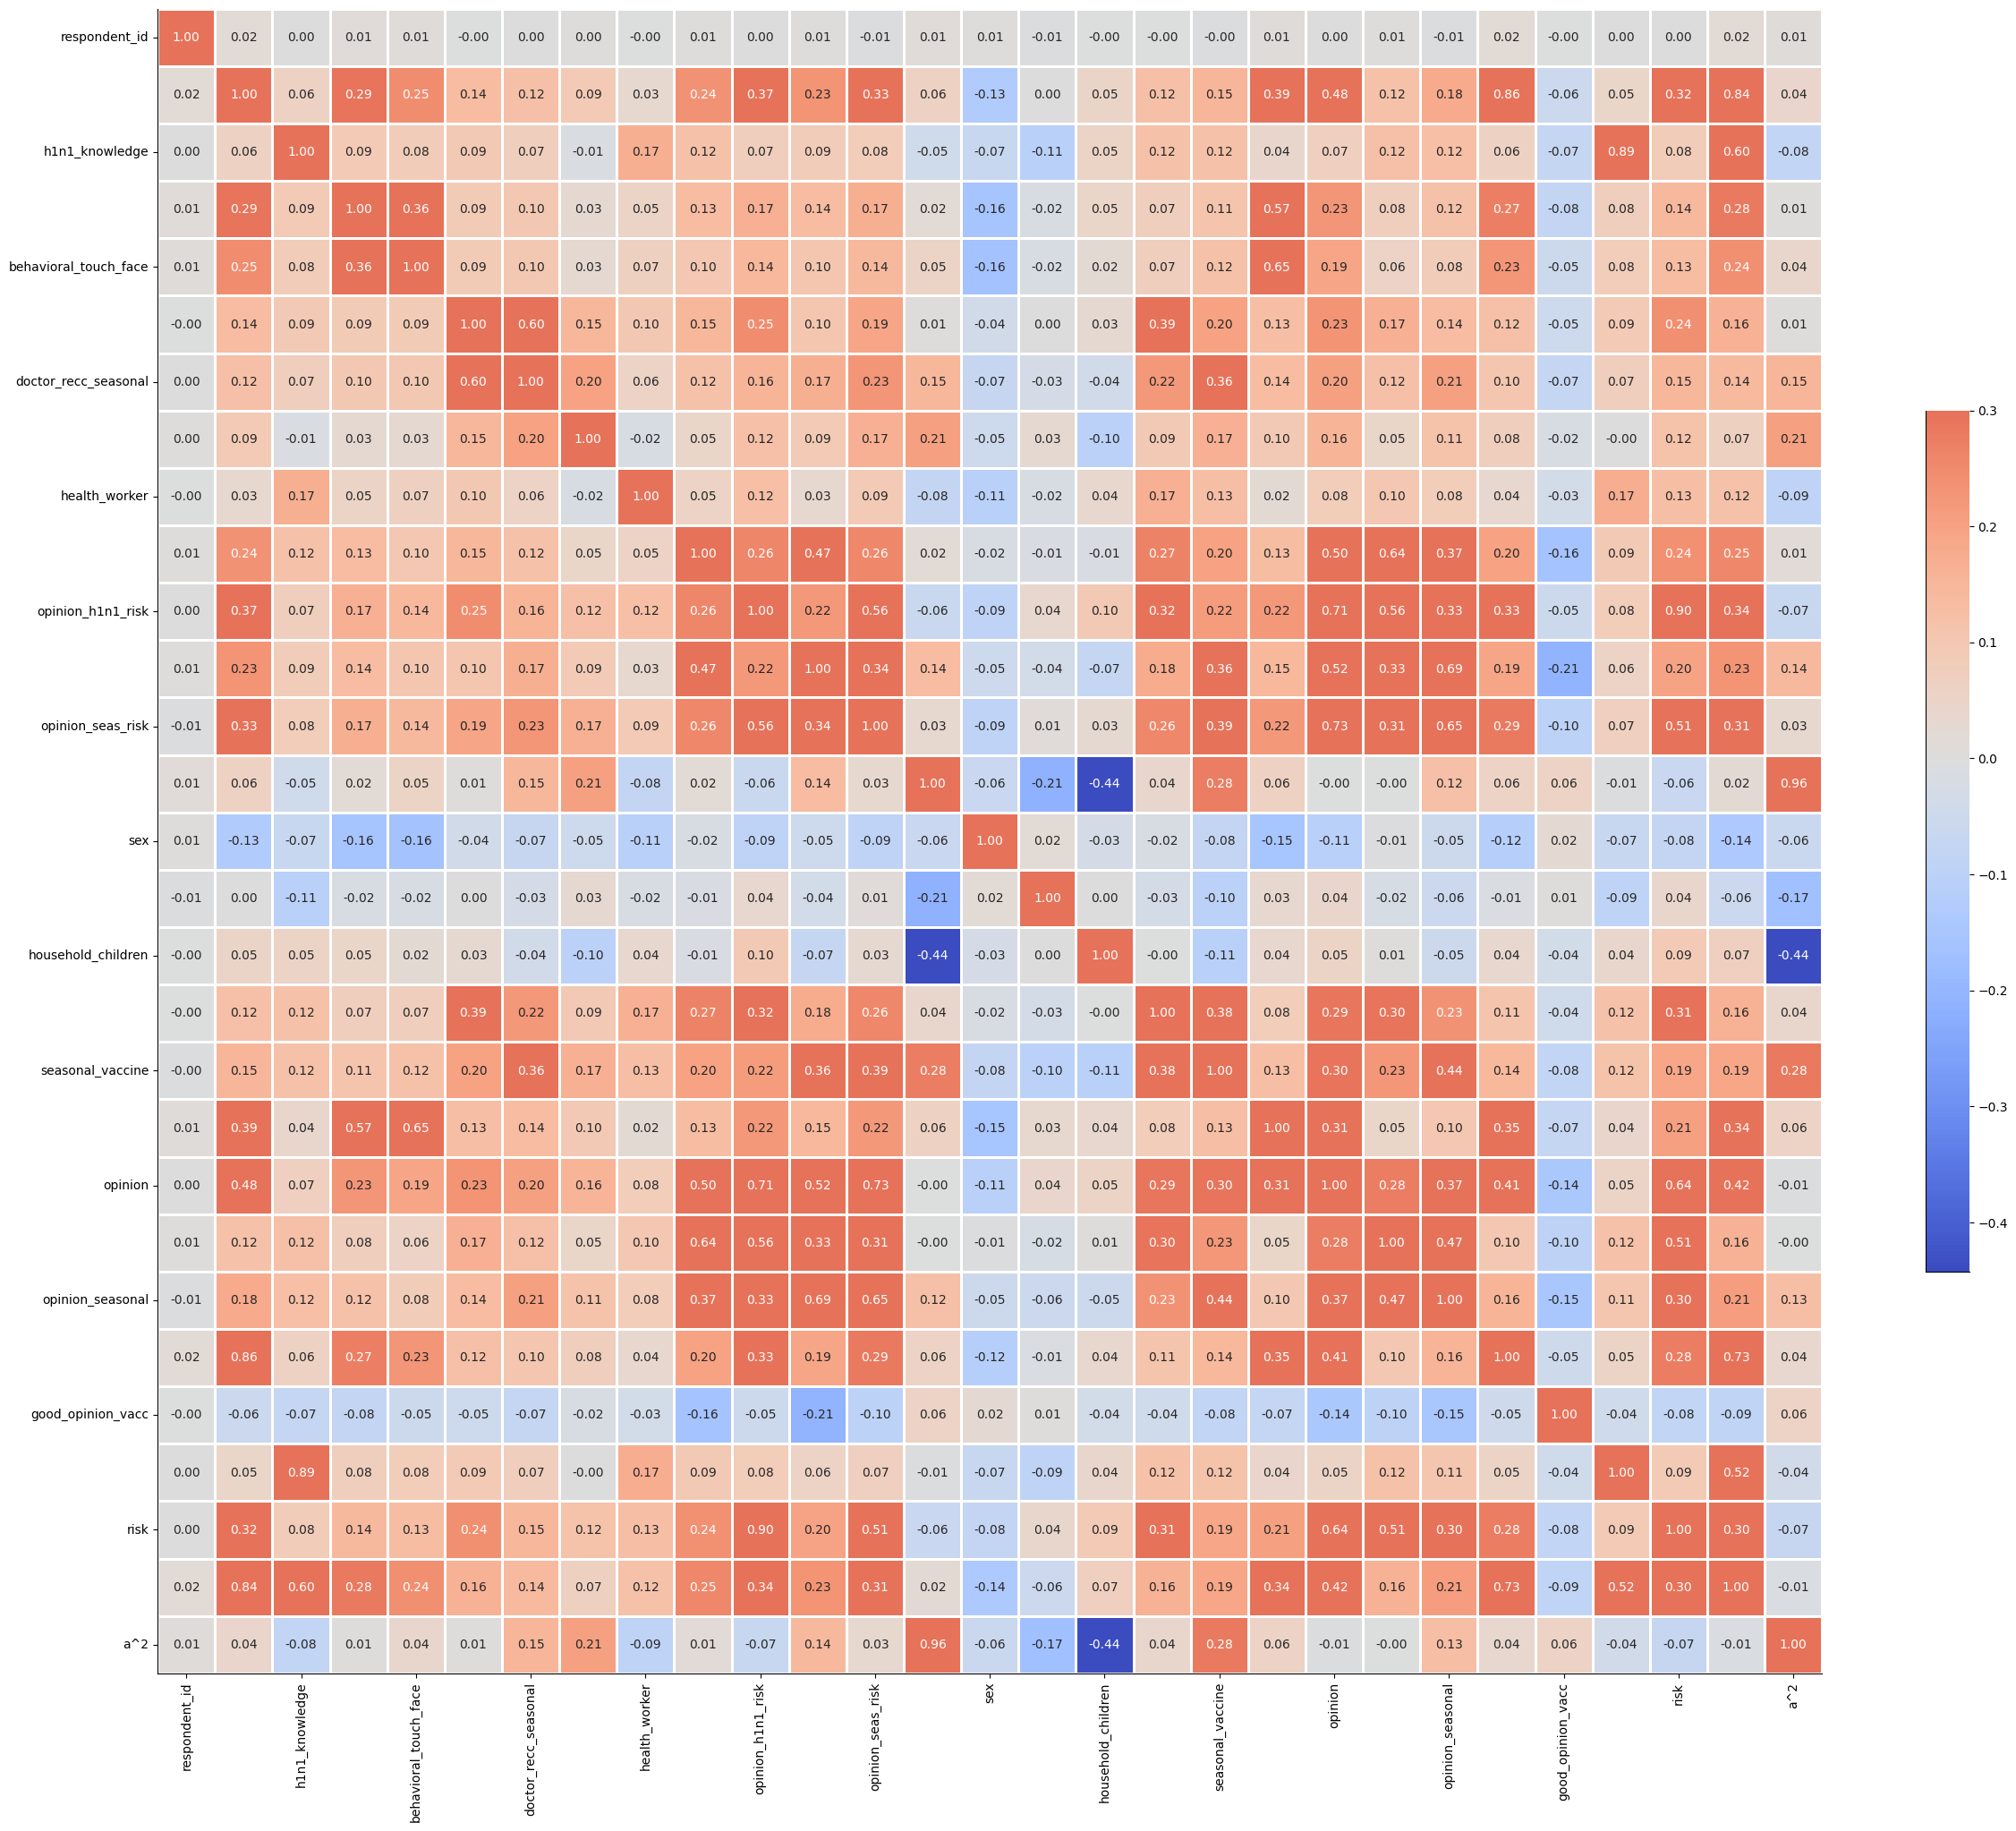

In [ ]:
corr = data.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
g.figure.set_size_inches(30,25)

plt.show()

### We now see that the current 26 features are very well/ atleast better correlated with the ground truth labels than the previous Map!!

In [ ]:
#### Appending Y labels to the end of the dataframe ####

data.drop(['respondent_id','h1n1_vaccine','seasonal_vaccine'],axis=1,inplace = True)
frames =[data,Y_label]
data = pd.concat(frames,axis=1)

In [ ]:
data.head()

,h1n1_concern,h1n1_knowledge,behavioral_wash_hands,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,...,opinion_h1n1,opinion_seasonal,concern>=2,good_opinion_vacc,good_knowledge,risk,concern_knowledge,a^2,h1n1_vaccine,seasonal_vaccine
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,...,2.0,1.0,0,0,0,0,1.0,9,0,0
1,3.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,4.0,...,5.0,2.0,1,0,1,1,5.0,1,0,1
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,...,3.0,3.0,0,0,0,0,2.0,0,0,0
3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,3.0,...,1.0,8.0,0,0,0,0,2.0,16,0,1
4,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,...,4.0,0.0,1,1,0,0,3.0,4,0,0


In [ ]:
features = data.columns[:-2]
print(features)
labels = ['h1n1_vaccine', 'seasonal_vaccine']

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_wash_hands',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'health_worker', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'age_group', 'sex', 'rent_or_own', 'household_children', 'cleanliness',
       'opinion', 'opinion_h1n1', 'opinion_seasonal', 'concern>=2',
       'good_opinion_vacc', 'good_knowledge', 'risk', 'concern_knowledge',
       'a^2'],
      dtype='object')


# 5. Data Splitting and Test data processing

### Choosing 80%, 20% for train and validation

In [ ]:
train,test = train_test_split(data,test_size = 0.2,shuffle = True)
train_x,train_y = train[features],train[labels]
test_x,test_y = test[features],test[labels]

In [ ]:
train_x.head()

,h1n1_concern,h1n1_knowledge,behavioral_wash_hands,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,...,cleanliness,opinion,opinion_h1n1,opinion_seasonal,concern>=2,good_opinion_vacc,good_knowledge,risk,concern_knowledge,a^2
8865,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,...,3.0,17.0,5.0,6.0,1,0,1,0,4.0,16
9186,3.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,5.0,4.0,...,4.0,24.0,7.0,5.0,1,0,0,1,4.0,16
1244,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,1.0,...,0.0,12.0,4.0,4.0,0,0,0,0,2.0,16
15393,3.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0,1.0,...,3.0,18.0,1.0,5.0,1,0,0,0,4.0,16
23454,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,2.0,...,5.0,18.0,4.0,8.0,1,0,1,0,4.0,4


In [ ]:
train_y.head()

,h1n1_vaccine,seasonal_vaccine
8865,0,1
9186,0,0
1244,1,1
15393,0,0
23454,0,1


In [ ]:
train_x.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_wash_hands',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'health_worker', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'age_group', 'sex', 'rent_or_own', 'household_children', 'cleanliness',
       'opinion', 'opinion_h1n1', 'opinion_seasonal', 'concern>=2',
       'good_opinion_vacc', 'good_knowledge', 'risk', 'concern_knowledge',
       'a^2'],
      dtype='object')

### A Utility function is defined below which performs the exact same preprocessing, encodings, feature engineering and other transformations (which was done on the train data) on the Test data given to us.

In [ ]:
def transform_test(Test_X):
    Test_X.drop(['respondent_id','health_insurance','employment_industry','employment_occupation'],axis=1,inplace = True)

    # All the NULL values are populated with the mode

    d = Test_X
    str_cols = d.select_dtypes(include = 'object').columns

    ### LabelEcoding all categorical types #####
    for col in Test_X.columns:
        if Test_X[col].isnull().sum() and Test_X[col].dtypes != 'object':
            Test_X[col].loc[(Test_X[col].isnull())] = Test_X[col].median()
    for col in Test_X.columns:
        if Test_X[col].isnull().sum() and Test_X[col].dtypes == 'object':
            Test_X[col].loc[(Test_X[col].isnull())] = Test_X[col].mode().max()
    LE = LabelEncoder()
    for col in str_cols:
        Test_X[col] = LE.fit_transform(Test_X[col]) # Converts to int64

    data = d
    ### Synthesizing two new features cleanliness level of the individual and opinion of vaccine ####
    data['opinion'] = data['opinion_h1n1_vacc_effective'] + data['opinion_h1n1_risk']+\
                  data['opinion_h1n1_sick_from_vacc'] + data['opinion_seas_vacc_effective']+\
                  data['opinion_seas_risk'] + data['opinion_seas_sick_from_vacc']
    data['cleanliness'] =  data['behavioral_antiviral_meds']+ data['behavioral_avoidance']+\
                        data['behavioral_face_mask']+data['behavioral_wash_hands']+\
                       data['behavioral_large_gatherings'] + data['behavioral_outside_home']+\
                       data['behavioral_touch_face']
    data['opinion_h1n1'] = data['opinion_h1n1_vacc_effective'] + data['opinion_h1n1_risk']-\
                      data['opinion_h1n1_sick_from_vacc']
    data['opinion_seasonal'] = data['opinion_seas_vacc_effective']+\
                      data['opinion_seas_risk'] - data['opinion_seas_sick_from_vacc']

    data['concern>=2'] = np.where(data['h1n1_concern']>=2,1,0)
    data['good_opinion_vacc'] = np.where(data['opinion_seas_vacc_effective'] == 3,1,0) # 5 before
    data['good_knowledge'] = np.where(data['h1n1_knowledge'] == 2,1,0)
    data['risk'] = np.where(data['opinion_h1n1_risk']>=4,1,0)
    data['concern_knowledge'] = data['h1n1_concern']+data['h1n1_knowledge']
    data['a^2'] = data['age_group']*data['age_group']
    ###### Dropping other features #########
    data.drop(['race','child_under_6_months','opinion_h1n1_sick_from_vacc','opinion_seas_sick_from_vacc','household_adults','behavioral_antiviral_meds','behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_antiviral_meds','marital_status',
           'behavioral_avoidance','behavioral_face_mask','income_poverty','hhs_geo_region','employment_status','education','census_msa'],axis=1,inplace = True)
    Test_X = data
    return Test_X

Loading and transforming test data

In [ ]:
Test_X = pd.read_csv('/content/drive/MyDrive/FINDIT 2023/test_set_features.csv')
Test_X.shape

(26708, 36)

In [ ]:
Test_X = transform_test(Test_X)

In [ ]:
Test_X.isnull().sum()

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_wash_hands          0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
health_worker                  0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
age_group                      0
sex                            0
rent_or_own                    0
household_children             0
opinion                        0
cleanliness                    0
opinion_h1n1                   0
opinion_seasonal               0
concern>=2                     0
good_opinion_vacc              0
good_knowledge                 0
risk                           0
concern_knowledge              0
a^2                            0
dtype: int64

Similarity Check!!

In [ ]:
Test_X.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_wash_hands',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'health_worker', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'age_group', 'sex', 'rent_or_own', 'household_children', 'opinion',
       'cleanliness', 'opinion_h1n1', 'opinion_seasonal', 'concern>=2',
       'good_opinion_vacc', 'good_knowledge', 'risk', 'concern_knowledge',
       'a^2'],
      dtype='object')

In [ ]:
train_x.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_wash_hands',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'health_worker', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'age_group', 'sex', 'rent_or_own', 'household_children', 'cleanliness',
       'opinion', 'opinion_h1n1', 'opinion_seasonal', 'concern>=2',
       'good_opinion_vacc', 'good_knowledge', 'risk', 'concern_knowledge',
       'a^2'],
      dtype='object')

In [ ]:
Test_X.head()

,h1n1_concern,h1n1_knowledge,behavioral_wash_hands,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,...,opinion,cleanliness,opinion_h1n1,opinion_seasonal,concern>=2,good_opinion_vacc,good_knowledge,risk,concern_knowledge,a^2
0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,1.0,...,14.0,4.0,5.0,5.0,1,0,1,0,4.0,1
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,...,12.0,0.0,4.0,4.0,0,0,0,0,2.0,0
2,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,4.0,...,24.0,5.0,7.0,5.0,1,0,1,1,4.0,9
3,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,2.0,...,18.0,0.0,4.0,6.0,0,0,0,0,2.0,16
4,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,5.0,2.0,...,21.0,6.0,3.0,6.0,1,0,0,0,4.0,1


# 6. Analyzing Several Models on the Dataset

In [ ]:
##### Model Generation #####

* ### **Remember that our task is not a Multi'Class' Classification problem, but instead a Multi'Label' Classification problem.**
* ### **Thus I have used the Binary Relevance Classifier to train a model to individually predict for each 'h1n1_vaccine' and for 'seasonal_vaccine' separately and later combine them to calculate the overall accuracy**

## 6.1 Ensembling with 20 Classifiers and Linear models <a id="ensemble"></a>

In [ ]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    #gaussian_process.GaussianProcessClassifier(),

    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),

    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),

    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),

    #SVM
    #svm.SVC(probability=True),
    #svm.NuSVC(probability=True),
    svm.LinearSVC(),

    #Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),


    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data['h1n1_vaccine']

#index through MLA and save performance to table
row_index = 0
data1 = data.copy()
for alg in MLA:
    data = data1
    #set name and parameters
    MLA_name = alg.__class__.__name__
    print('Executing ',MLA_name)
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data[features], data['h1n1_vaccine'], cv  = cv_split)
    #print(cv_results.keys())
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    #MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!

    #save MLA predictions - see section 6 for usage
    alg.fit(data[features], data['h1n1_vaccine'])
    MLA_predict[MLA_name] = alg.predict(data[features])
    row_index+=1


#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict


Executing  AdaBoostClassifier
Executing  BaggingClassifier
Executing  ExtraTreesClassifier
Executing  GradientBoostingClassifier
Executing  RandomForestClassifier
Executing  LogisticRegressionCV
Executing  PassiveAggressiveClassifier
Executing  RidgeClassifierCV
Executing  SGDClassifier
Executing  Perceptron
Executing  BernoulliNB
Executing  GaussianNB
Executing  KNeighborsClassifier
Executing  LinearSVC
Executing  DecisionTreeClassifier
Executing  ExtraTreeClassifier
Executing  LinearDiscriminantAnalysis
Executing  QuadraticDiscriminantAnalysis
Executing  XGBClassifier


,MLA Name,MLA Parameters,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.835605,0.007533,2.461535
5,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.834007,0.007859,5.727181
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': 'de...",0.832722,0.003688,0.775678
16,LinearDiscriminantAnalysis,"{'covariance_estimator': None, 'n_components':...",0.830388,0.009794,0.150102
7,RidgeClassifierCV,"{'alphas': (0.1, 1.0, 10.0), 'class_weight': N...",0.82899,0.007409,0.089564
18,XGBClassifier,"{'objective': 'binary:logistic', 'use_label_en...",0.827281,0.010156,2.752826
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.825908,0.010938,2.057462
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.820567,0.008601,2.240013
1,BaggingClassifier,"{'base_estimator': 'deprecated', 'bootstrap': ...",0.811831,0.010257,0.902061
8,SGDClassifier,"{'alpha': 0.0001, 'average': False, 'class_wei...",0.81107,0.043523,0.606917


Text(0, 0.5, 'Algorithm')

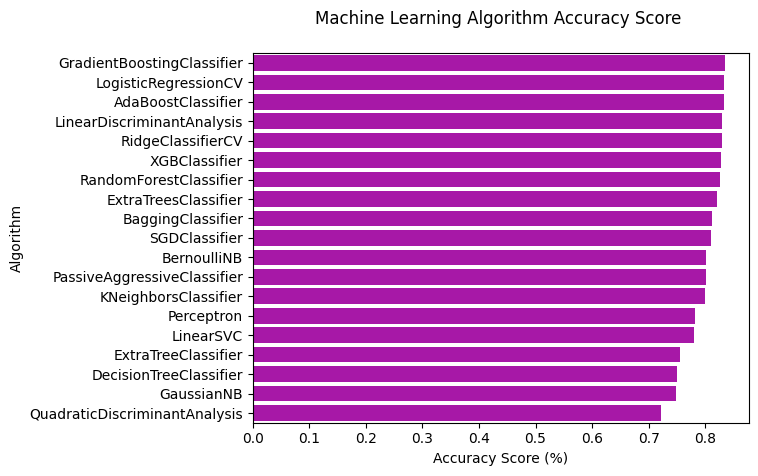

In [ ]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [ ]:
#### Utility Function to print the accuracy of the model ###

def find_acc(clf,X,truth,s):
    pred = clf.predict_proba(X.values)
    pred = pred.toarray()
    accuracy = roc_auc_score(truth,pred)
    print(s+" Accuracy is : ",accuracy*100)

<a id="hpo"></a>
## 6.2 Trying out Hyper Parameter Optimization (HPO) on some Select Models.

Tried out HPO with

    1. Grid Search CV
    2. Randomized Search CV

### Check out the model and technique of HPO used in the comments given in each cell

In [ ]:
#### Random Forest Classifier with Grid Search CV for HPO #####

from sklearn.model_selection import GridSearchCV
grid_1 = {      "n_estimators"      : [100,200,500],
               "criterion"         : ["gini", "entropy"],
               "max_features"      : ['sqrt','log2',0.2,0.5,0.8],
               "max_depth"         : [3,4,6,10],
               "min_samples_split" : [2, 5, 20,50] }
RF=RandomForestClassifier()
gs = GridSearchCV(RF, grid_1, n_jobs=-1, cv=2,verbose = True)

In [ ]:
#!pip install numpy==1.22.0
#print(np.__version__)

In [ ]:
### Training & Performance ###

clf = BinaryRelevance(classifier=gs, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

Fitting 2 folds for each of 480 candidates, totalling 960 fits
Fitting 2 folds for each of 480 candidates, totalling 960 fits
Training Accuracy is :  88.11602047778608
Cross Validation Accuracy is :  85.04429134477306


In [ ]:
#### Random Forest Classifier with Randomized Search CV for HPO #####

from sklearn.model_selection import RandomizedSearchCV
n_estimators = [100,200,500]
#max_features = ['auto', 'sqrt']
max_depth = [15,20,25]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               #'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RF
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20,\
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
### Training & Performance ###
clf = BinaryRelevance(classifier=rf_random, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Training Accuracy is :  94.4530271460968
Cross Validation Accuracy is :  84.8206828862447


### A sample NN model for reference

In [ ]:
## Neural Network based Classifier on Keras sample ##

def NN_classifier(input_dim,output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(25,input_dim=input_dim,activation = 'relu'),
        tf.keras.layers.Dense(128,activation = 'relu'),
        tf.keras.layers.Dense(64,activation = 'relu'),
        tf.keras.layers.Dense(output_dim,activation = 'softmax')
    ])
    model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    return model

In [ ]:
from sklearn.model_selection import GridSearchCV
param2 = {
            'learning_rate':     [0.01,0.1],
            'max_depth':         [2,3,4],
            'lambda':            [1.0,1.5],
            'subsample':        [0.1,0.2,0.3],
            'colsample_bytree': [0.3,0.5,0.6],
            'min_split_loss' :  [0.01,0.2],
            'min_split_size' : [2,4,6]
        }
classifier = XGBClassifier(feature_names = features,verbose = False)
xgb = GridSearchCV(classifier, param2, n_jobs=-1, cv=2,verbose = True)

In [ ]:
### Training & Performance ###
clf = BinaryRelevance(classifier=xgb, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

Fitting 2 folds for each of 648 candidates, totalling 1296 fits
[07:39:34] WARNING: ../src/learner.cc:767: 
Parameters: { "feature_names", "min_split_size", "verbose" } are not used.

Fitting 2 folds for each of 648 candidates, totalling 1296 fits
[07:50:12] WARNING: ../src/learner.cc:767: 
Parameters: { "feature_names", "min_split_size", "verbose" } are not used.

Training Accuracy is :  84.758334645094
Cross Validation Accuracy is :  85.16325305384423


In [ ]:
#### Random Forest Classifier with Randomized Search CV for HPO #####

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [100,200]
max_features = ['auto', 'sqrt']
max_depth = [2,3,7,5,15,20,25]
max_depth.append(None)
min_samples_split = [0.2,0.3,0.6,1.2,1.5,2.0,3.0,4.0]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = XGBClassifier(feature_names = features,verbose = False)
etc = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20,\
                               cv = 4, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
### Training & Performance ###
clf = BinaryRelevance(classifier=etc, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[07:57:57] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "feature_names", "max_features", "min_samples_leaf", "min_samples_split", "verbose" } are not used.

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[08:05:53] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "feature_names", "max_features", "min_samples_leaf", "min_samples_split", "verbose" } are not used.

Training Accuracy is :  85.00023940382482
Cross Validation Accuracy is :  85.31016517341052


In [ ]:
cb_hps = {
            'depth':              [2,3,4,5,7],
            'l2_leaf_reg':        [2,3,5,10],
            'random_seed':        [5,8,10],
            'colsample_bylevel': [0.3,0.5,0.6],
            'n_estimators':      [100,200]
        }

cb = CatBoostClassifier()
cbt = RandomizedSearchCV(estimator = cb, param_distributions = cb_hps, n_iter = 20,\
                               cv = 4, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
### Training & Performance ###

clf = BinaryRelevance(classifier=cbt, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

Fitting 4 folds for each of 20 candidates, totalling 80 fits
0:	learn: 0.6721668	total: 60.2ms	remaining: 12s
1:	learn: 0.6523812	total: 70ms	remaining: 6.93s
2:	learn: 0.6341956	total: 79.8ms	remaining: 5.24s
3:	learn: 0.6179268	total: 89ms	remaining: 4.36s
4:	learn: 0.6021777	total: 98ms	remaining: 3.82s
5:	learn: 0.5879582	total: 107ms	remaining: 3.45s
6:	learn: 0.5746360	total: 117ms	remaining: 3.22s
7:	learn: 0.5622477	total: 126ms	remaining: 3.03s
8:	learn: 0.5500091	total: 136ms	remaining: 2.89s
9:	learn: 0.5388995	total: 147ms	remaining: 2.8s
10:	learn: 0.5283392	total: 158ms	remaining: 2.72s
11:	learn: 0.5192735	total: 168ms	remaining: 2.63s
12:	learn: 0.5105316	total: 179ms	remaining: 2.57s
13:	learn: 0.5025547	total: 188ms	remaining: 2.5s
14:	learn: 0.4955549	total: 198ms	remaining: 2.44s
15:	learn: 0.4884258	total: 208ms	remaining: 2.39s
16:	learn: 0.4815956	total: 218ms	remaining: 2.34s
17:	learn: 0.4753917	total: 227ms	remaining: 2.3s
18:	learn: 0.4700060	total: 237ms	rem

In [ ]:
#### Training a binary relevance classifier for the two labels h1n1 vaccine and seasonal vaccine #####

classifier = CatBoostClassifier(
n_estimators = 300,depth = 5,l2_leaf_reg =0.5,
                                random_seed = 2,colsample_bylevel = 0.9,verbose = False)

In [ ]:
### Training & Performance ###

clf = BinaryRelevance(classifier=classifier, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

Training Accuracy is :  85.35295422274889
Cross Validation Accuracy is :  85.39953692577767


# 7. Final Notes & Submission

1. We see that our training accuracies are consistently within the range of 85% - 90%
2. Our validation accuracies are also close to the training accuracies which indicates that the model hasn't fallen prey to overfitting/bias
3. Feel free to tweak around with any of the values of the hyper-parameters or fiddle with the models. These were the best results that i could obtain with the given models
4. I have tried to demonstrate as many different model performances to minimize your time in developing a better more accurate model!

### Preparing the submission file in the specified format as given in 'submission_format.csv'

In [ ]:
submission = clf.predict_proba(Test_X.values)
#submission_df = pd.read_csv('/content/drive/MyDrive/FINDIT 2023/submission_format.csv')

In [ ]:
submission = clf.predict_proba(Test_X.values)
submission_df = pd.DataFrame.sparse.from_spmatrix(submission)

In [ ]:
trial = submission_df
trial['respondent_id'] = trial.index+26707 # Converting the default indices
trial['h1n1_vaccine'] = trial[0].astype('float64') # Data required to be in float64
trial['seasonal_vaccine'] = trial[1].astype('float64')
trial.set_index('respondent_id') # Make index as respondent_id
trial.drop([0,1],axis=1,inplace=True) # Drop old index axis
submission_df = trial

In [ ]:
#Our Predictive Result
submission_df # Check if all OK

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.093561,0.155821
1,26708,0.041022,0.047915
2,26709,0.397195,0.660970
3,26710,0.467962,0.903113
4,26711,0.315369,0.574961
...,...,...,...
26703,53410,0.275555,0.460805
26704,53411,0.153351,0.310143
26705,53412,0.119690,0.188208
26706,53413,0.058623,0.370810


In [ ]:
submission_df.to_csv('submission.csv',index = False)